In [1]:
# Necessary imports
import os
import sys
import warnings

import numpy as np
warnings.filterwarnings("ignore")

sys.path.insert(0, "seismiqb")
from seismiqb.batchflow import Pipeline, FilesIndex, B, D, V
from seismiqb.batchflow.models.torch import EncoderDecoder

from seismiqb import SeismicCubeset, Horizon, plot_image

# Set GPU
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
CUBE_PATH = 'amplitudes.hdf5'
MODEL_PATH = 'm_carcass'

CROP_SHAPE = (1, 256, 256)

In [3]:
%%time
dsi = FilesIndex(path=[CUBE_PATH], no_ext=True)
dataset = SeismicCubeset(dsi)

dataset.load_geometries(logs=False)
geometry = dataset.geometries[0]

CPU times: user 15.4 ms, sys: 0 ns, total: 15.4 ms
Wall time: 14.8 ms


In [4]:
inference_template = (
    Pipeline()
    # Load model from the disk
    .init_variable('result_preds', [])
    .init_model('static', 'model', EncoderDecoder,
                {'load/path': MODEL_PATH})

    # Load data/masks
    .make_locations(points=D('grid_gen')(), shape=CROP_SHAPE)
    .load_cubes(dst='images')
    .adaptive_reshape(src=['images'], shape=CROP_SHAPE)
    .normalize(mode='q', src='images')
    
    # Make model prediction
    .predict_model('model',
                   B('images'),
                   fetches='sigmoid',
                   save_to=V('result_preds', mode='e'))
)

In [5]:
dataset.make_grid(dataset.indices[0], CROP_SHAPE,
                  [0, 1], [0, 868], [0, 2001],
                  strides=(1, 96, 96),
                  batch_size=16)

inference_pipeline = inference_template << dataset
inference_pipeline.run(D('size'), n_iters=dataset.grid_iters, bar='n')

assembled_pred = dataset.assemble_crops(inference_pipeline.v('result_preds'), order=(0, 1, 2))

  0%|                                                                                                         …

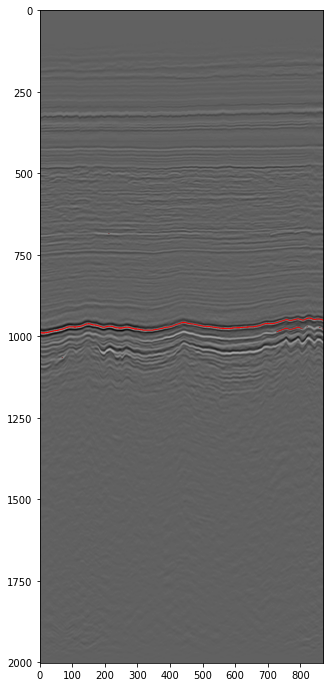

In [6]:
plot_image((geometry.load_slide(0), (assembled_pred > 0.2).astype(int)),
           mode='overlap', figsize=(15, 12), savepath='result.png')